In [1]:
import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

# Lecture 31: Classification

## Chronic Kidney Disease

In [2]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1


In [3]:
ckd.group('Class')

Class,count
0,115
1,43


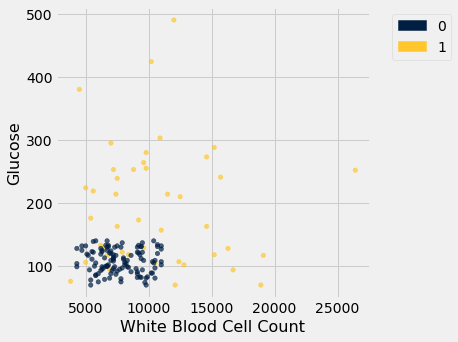

In [4]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Class')

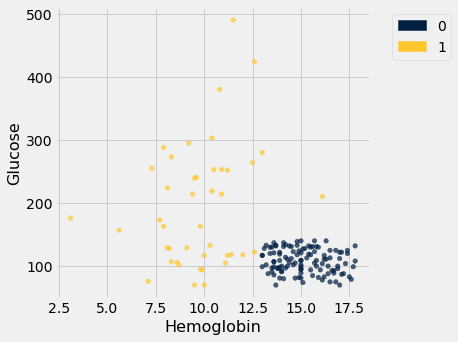

In [5]:
ckd.scatter('Hemoglobin', 'Glucose', colors='Class')

## Fraudulent Banknotes

In [6]:
banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


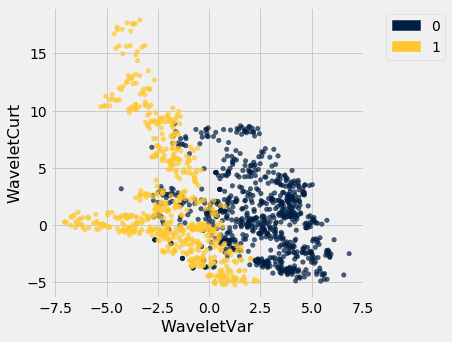

In [7]:
banknotes.scatter('WaveletVar', 'WaveletCurt', colors='Class')

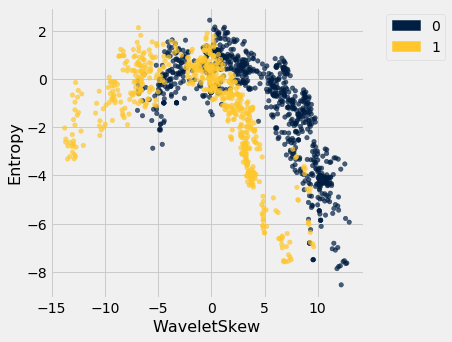

In [8]:
banknotes.scatter('WaveletSkew', 'Entropy', colors='Class')

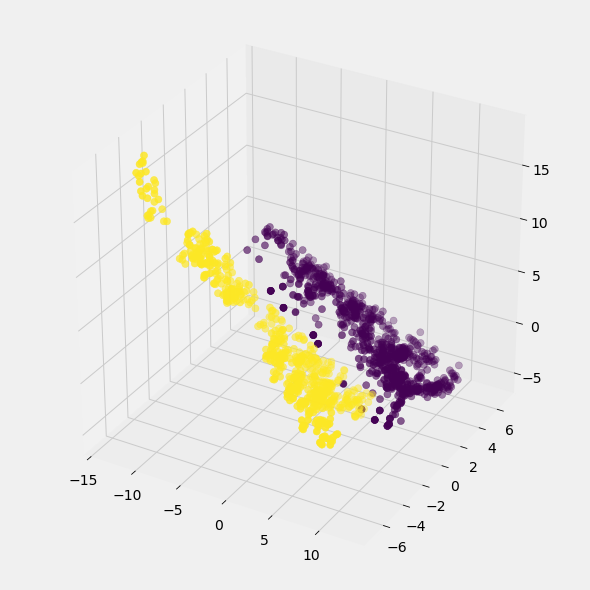

In [24]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='viridis',
          s=50);

## Back to Chronic Kidney Disease

... this time in standard units!

These functions are copied directly from the demo in Ch 17 of textbook, don't focus too much on the code and instead try to understand the big picture idea.

In [10]:
# Don't worry about these functions too much!

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [11]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

color_table = Table().with_columns(
    'Class', make_array(0, 1),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

In [12]:
ckd

Class,Hemoglobin,Glucose,White Blood Cell Count,Color
0,0.456884,0.133751,0.617283,darkblue
0,1.153,-0.947597,0.424788,darkblue
0,0.770138,-0.762223,0.200211,darkblue
0,0.596108,-0.190654,-0.73018,darkblue
0,-0.239236,-0.49961,-0.0564489,darkblue
0,-0.0304002,-0.159758,0.232293,darkblue
0,0.282854,-0.00527964,0.71353,darkblue
0,0.108824,-0.623193,0.200211,darkblue
0,0.0740178,-0.515058,-0.0243664,darkblue
0,0.83975,-0.422371,-1.33975,darkblue


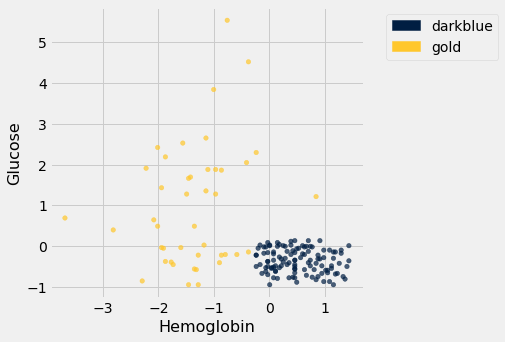

In [13]:
ckd.scatter('Hemoglobin', 'Glucose', colors='Color')

In [14]:
def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(1)
    y_closest = t.row(0).item(2)
    ckd.scatter('Hemoglobin', 'Glucose', colors='Class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

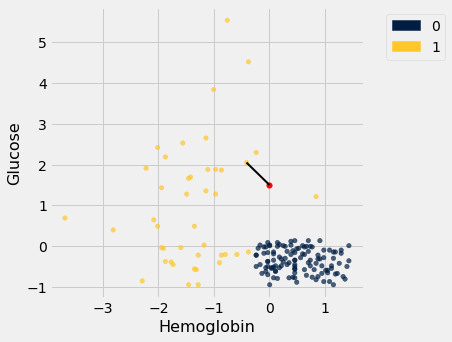

In [15]:
# In this example, Vinitra's Hemoglobin attribute is 0 and her Glucose is 1.5.

vinitra = make_array(0, 1.5)
show_closest(vinitra)

### Decision boundary ###

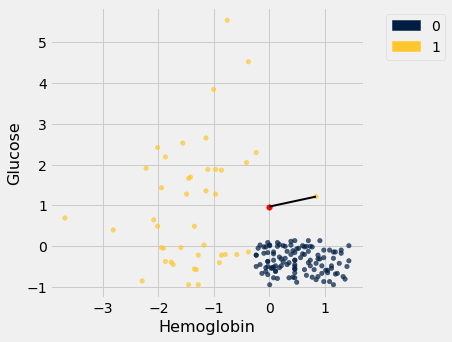

In [16]:
vinitra = make_array(0, 0.97)
show_closest(vinitra)

Here are hundreds of new unclassified points, all in red.

In [17]:
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

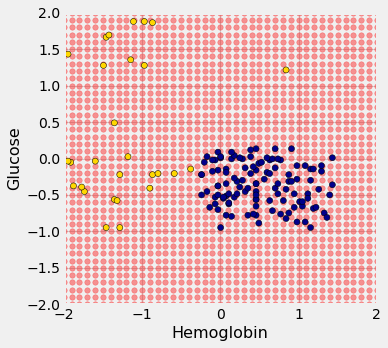

In [18]:
test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2);

In [19]:
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

c = classify_grid(ckd.drop('White Blood Cell Count', 'Color'), test_grid, 1)

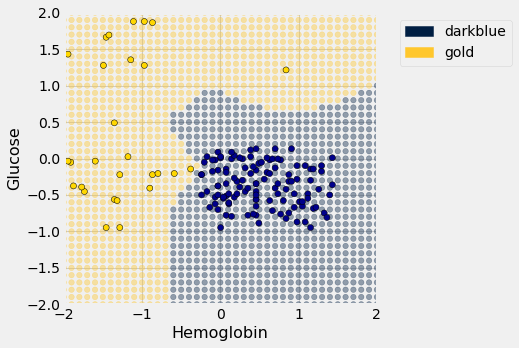

In [22]:
test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('Hemoglobin', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2);